# AI for Science Training - Week 03

### Damyn Chipman - Boise State University

## Advanced Neural Networks

## Homework: Network Experimentation

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

---

## Homework Submission

The goal of this homework is to experiment with different network architectures to see if we can get better "performance". The performance will be measured using a test dataset, with the model trained on a training dataset. Our baseline will be based on the performance of the network outlined in this week's presentation:

- Training Loss = 0.076
- Training Acc. = 97.262
- Validation Loss = 0.874
- Validation Acc. = 78.016

### Training, Validation, and Test Datasets

In [12]:
import torch, torchvision
from torchvision.transforms import v2
from torch import nn
from PIL import Image
from matplotlib import pyplot as plt
from torchinfo import summary
from tqdm.notebook import tqdm

In [13]:
training_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=True,
    download=False,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=False,
    download=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=4)
validation_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=4)

dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
validation_dataloader = WrappedDataLoader(validation_dataloader, preprocess)
test_dataloader = WrappedDataLoader(test_dataloader, preprocess)

### Classifier

In [14]:
class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [15]:
model = Classifier(128, 4, 2)
model.cuda()
print(summary(model, input_size=(batch_size, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 128, 32, 32]        512
├─LayerNorm: 1-2                         [128, 128, 32, 32]        262,144
├─Sequential: 1-3                        [128, 1024, 4, 4]         --
│    └─ConvNextBlock: 2-1                [128, 128, 32, 32]        --
│    │    └─Conv2d: 3-1                  [128, 128, 32, 32]        6,400
│    │    └─LayerNorm: 3-2               [128, 128, 32, 32]        262,144
│    │    └─Conv2d: 3-3                  [128, 512, 32, 32]        66,048
│    │    └─Conv2d: 3-4                  [128, 128, 32, 32]        65,664
│    └─ConvNextBlock: 2-2                [128, 128, 32, 32]        --
│    │    └─Conv2d: 3-5                  [128, 128, 32, 32]        6,400
│    │    └─LayerNorm: 3-6               [128, 128, 32, 32]        262,144
│    │    └─Conv2d: 3-7                  [128, 512, 32,

In [16]:
def evaluate(dataloader, model, loss_fn, progress_bar=None):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if progress_bar is not None:
                progress_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [17]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar=None):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        if progress_bar is not None:
            progress_bar.update()

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

### Training and Validation

In order to show better performance, the code below plots the loss and accuracy for the training and validation datasets. The dashed line indicates the performance of the model developed in this week's presentation.

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.7523994514355645, accuracy: 36.509085463258785


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Validation loss: 1.7481, validation accuracy: 36.62%


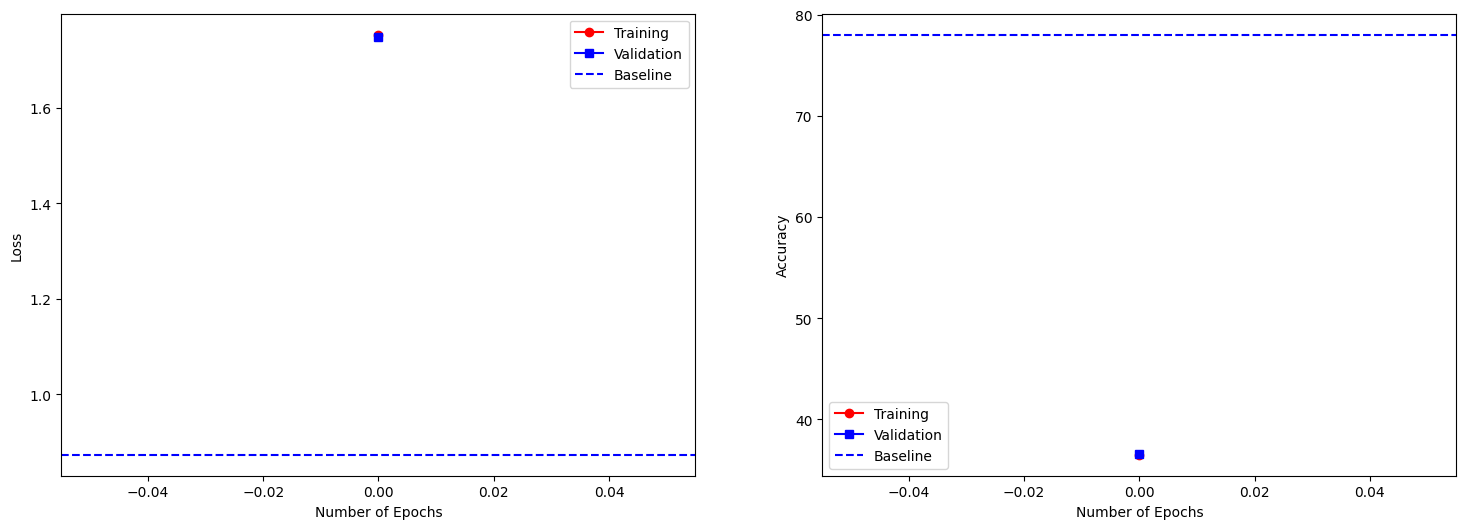

Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.5731548813585274, accuracy: 44.18929712460064


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.3256407926638667, accuracy: 51.594948083067095


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 1.202623316845574, accuracy: 56.70926517571885


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 1.0776869688932889, accuracy: 61.256988817891376


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Validation loss: 1.1475, validation accuracy: 58.00%


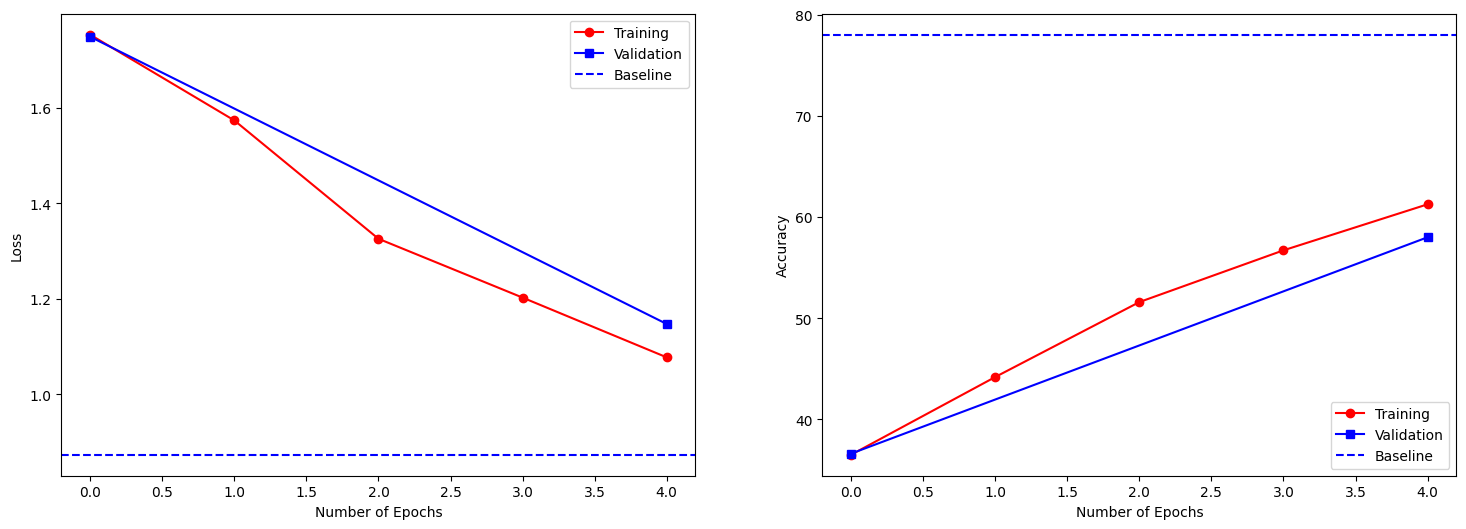

Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.9833639755416602, accuracy: 65.27555910543131


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.8871974211912186, accuracy: 68.70507188498402


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.7424969330382424, accuracy: 73.95167731629392


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.6312545698862106, accuracy: 77.88288738019169


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Validation loss: 0.8362, validation accuracy: 70.17%


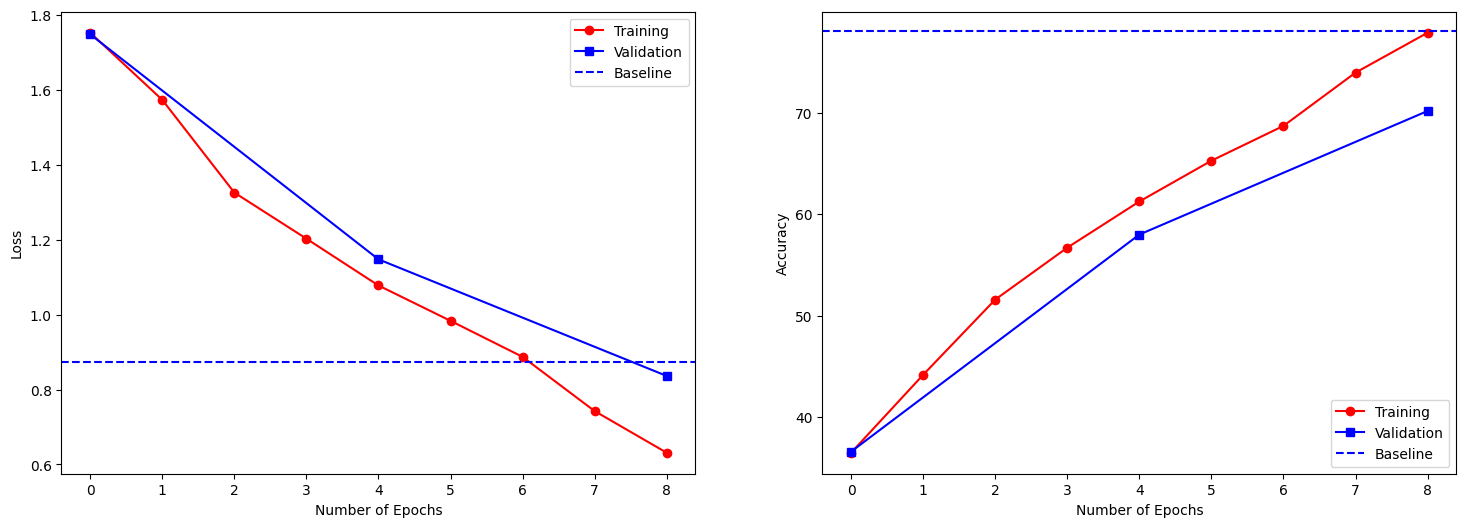

Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.5493372353121114, accuracy: 80.89556709265176


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.5055129848920499, accuracy: 82.24341054313099


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.3938412877698295, accuracy: 86.66633386581469


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.3640718768103816, accuracy: 87.44508785942492


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Validation loss: 0.7702, validation accuracy: 74.13%


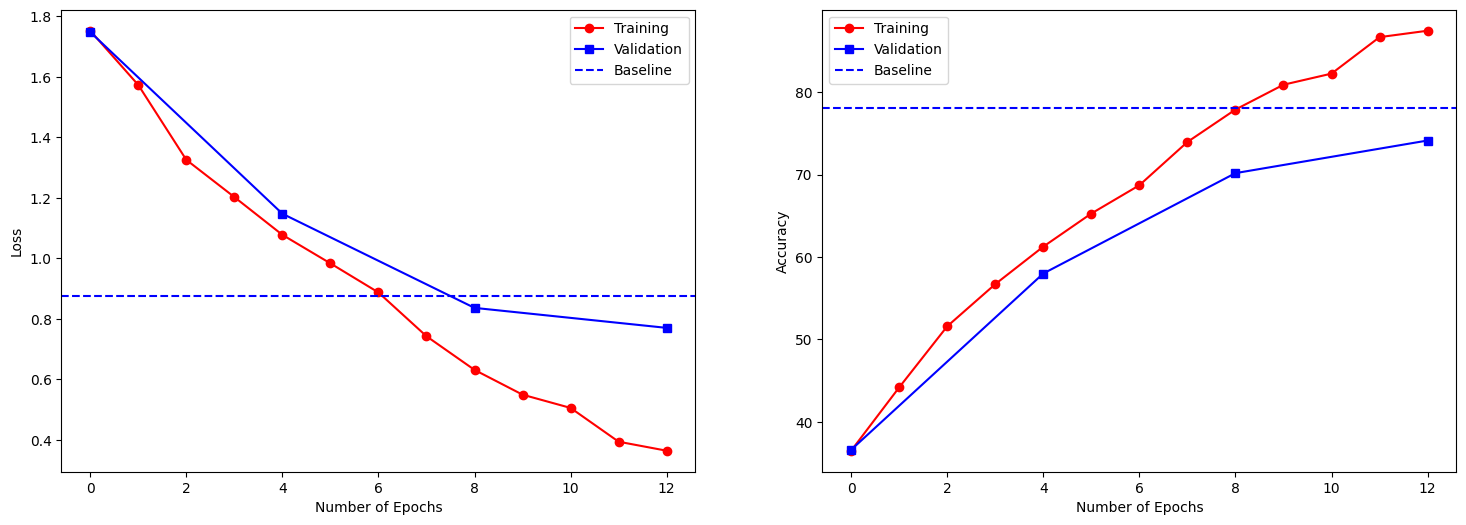

Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.29464394320695164, accuracy: 89.99850239616613


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.2362981016833942, accuracy: 91.92791533546327


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.21309606811870782, accuracy: 92.58186900958466


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.1750561320743622, accuracy: 93.92472044728434


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Validation loss: 0.7664, validation accuracy: 76.86%


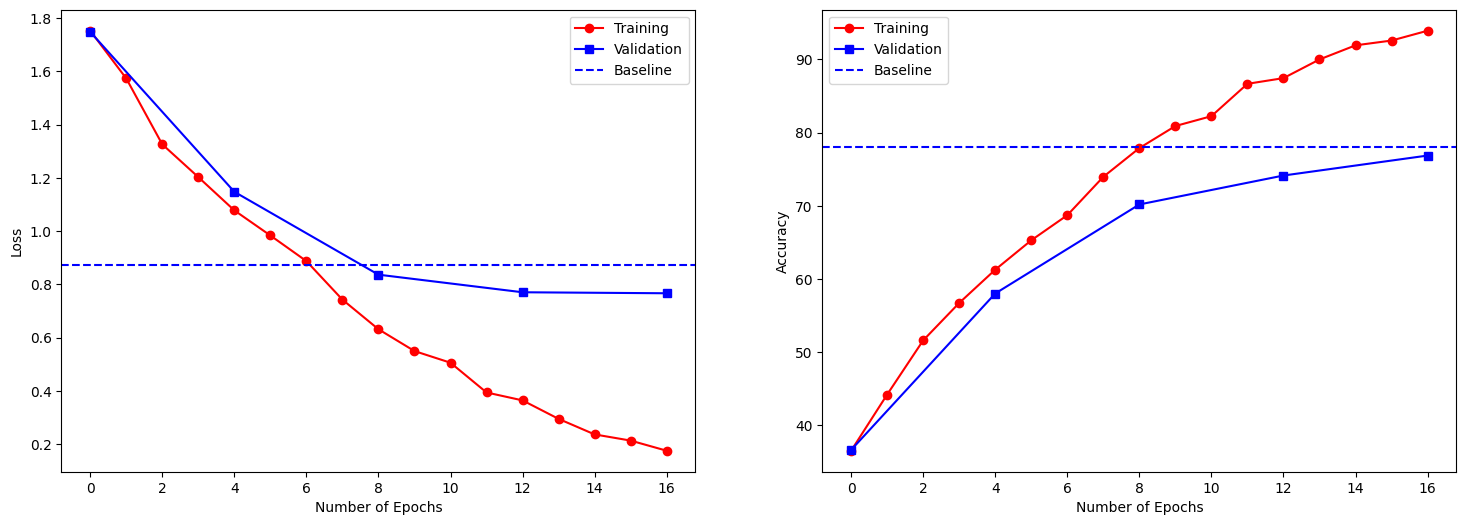

Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.17980364031685045, accuracy: 93.69259185303514


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.13444633823566543, accuracy: 95.3449480830671


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.12953621002669913, accuracy: 95.52715654952077


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Validation loss: 0.7899, validation accuracy: 77.95%


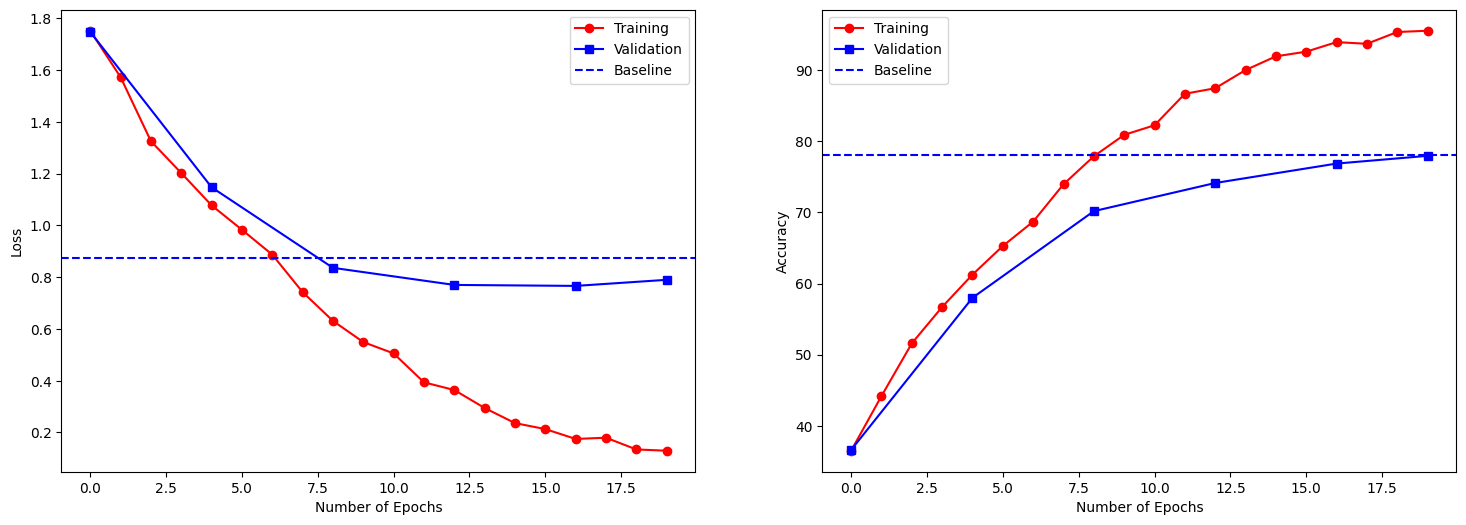

CPU times: user 9min 41s, sys: 6min 20s, total: 16min 2s
Wall time: 7min 54s


In [19]:
%%time

train_epoch_array = []
train_accuracy_array = []
train_loss_array = []
validation_epoch_array = []
validation_loss_array = []
validation_accuracy_array = []

epochs = 20
n_validations = 5
check_validation = epochs // n_validations
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, progress_bar=train_bar)
    
    # checking on the training loss and accuracy once per epoch
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, progress_bar=train_eval)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    train_epoch_array.append(j)
    train_accuracy_array.append(acc)
    train_loss_array.append(loss)
    
    if j % check_validation == 0 or j == epochs - 1:
        # do a validation check
        with tqdm(total=len(validation_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
            acc_val, loss_val = evaluate(validation_dataloader, model, loss_fn, progress_bar=val_bar)
        print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))
        validation_epoch_array.append(j)
        validation_loss_array.append(loss_val)
        validation_accuracy_array.append(acc_val)
    
        # update metrics plot
        fig, axes = plt.subplots(1, 2, figsize=(18,6), dpi=100)

        axes[0].plot(train_epoch_array, train_loss_array, 'or-', label='Training')
        axes[0].plot(validation_epoch_array, validation_loss_array, 'sb-', label='Validation')
        axes[0].axhline(y=0.874, color='b', ls='--', label='Baseline')
        axes[0].set_xlabel('Number of Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].legend()

        axes[1].plot(train_epoch_array, train_accuracy_array, 'or-', label='Training')
        axes[1].plot(validation_epoch_array, validation_accuracy_array, 'sb-', label='Validation')
        axes[1].axhline(y=78.016, color='b', ls='--', label='Baseline')
        axes[1].set_xlabel('Number of Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()

        plt.show()

### Discussion

I experimented with a variety of model parameters in order to get better performance out of this classifier. The results currently shown are the result of simply doubling the number of initial filters. I believe this makes a difference because we expand the data into more possible tokens (the initial "patchify" layer emulates tokenizing the images).

Other approaches included increasing the number of stages and number of blocks per stage, with little success. By adding more layers, we make the network even deeper. Without residual layers or other techniques to handle the "vanishing gradient" problem, increasing the number of layers leads to poorer performance.